# Overview of Pandas in Cheminformatics

## Requirements for notebook
!pip install pandas numpy seaborn 

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [105]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/ChEMBL_hERG.csv")
df.head()
df.shape

(8989, 13)

In [106]:
# Determine data types that will assist in the analysis and 
#determining what preprocessing is required for the data before training ML.
df.dtypes # Data types of each column e.g. object, int64, float64
df.columns # Names of each column
df.describe() # Summary statistics
len(df.molregno.unique()) # Number of unique molecules - Non-duplicates


7438

In [107]:
# Converting datatypes from interger to object
df.molregno = df.mol_chembl_id.astype(object)
df.dtypes

canonical_smiles      object
molregno              object
mol_chembl_id         object
standard_relation     object
standard_value       float64
standard_type         object
standard_units        object
description           object
organism              object
assay_type            object
confidence_score       int64
pref_name             object
tgt_chembl_id         object
dtype: object

<Axes: xlabel='assay_type'>

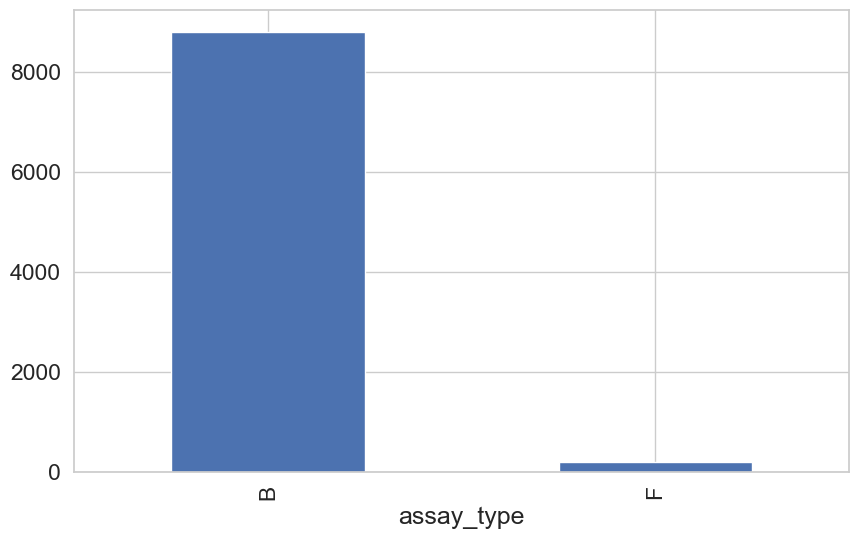

In [108]:
df.assay_type.value_counts()
# plot the assay types
df.assay_type.value_counts().plot(kind='bar', figsize=(10,6))

In [109]:
# From the plt we can see that we will only use assay type B for analysis
df = df.query("assay_type == 'B'")
df.shape

(8791, 13)

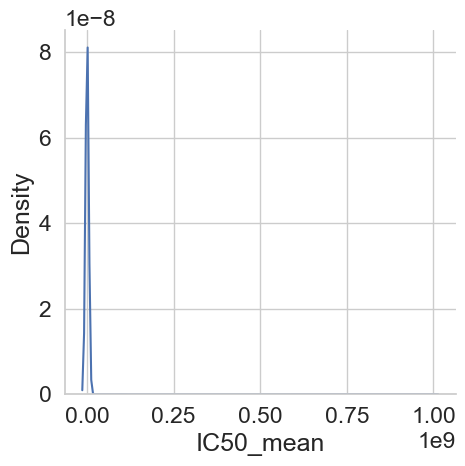

In [124]:
# Aggregating Data to combine rows with duplicate molecules
duplicates_removed = df.groupby('molregno')

# Iterate of name and calculate the mean of the IC50 values ad save into a list.
ic50_mean = []
for k,v in duplicates_removed:
    ic50_mean.append([k,v.standard_value.mean()])

#Create new dataframe with averaged IC50 values

ic50_mean_df = pd.DataFrame(ic50_mean, columns=['name', 'IC50_mean'])   
ic50_mean_df.shape

#Set plot variables
sns.set_theme(rc={'figure.figsize':(10,6)})
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid")

#Plot the distribution of IC50 values
sns.displot(ic50_mean_df['IC50_mean'], kind='kde')


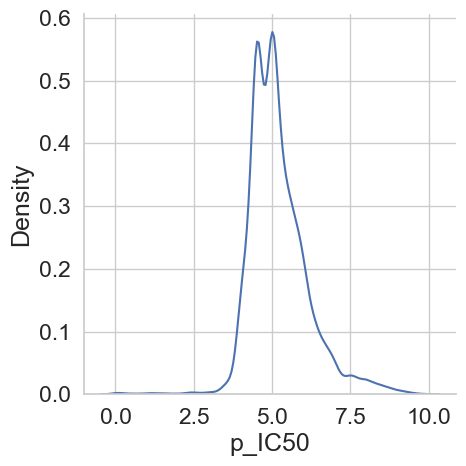

In [111]:
# The data is compressed on the plot and not useful. We will use a log scale to view the data.
# We use the pIC50 whic is the negative log of IC50
ic50_mean_df["p_IC50"] = -np.log10(ic50_mean_df["IC50_mean"] * 1e-9)
ic50_mean_df["p_IC50"].head()

# Visualize the distribution of pIC50 values
ax = sns.displot(ic50_mean_df["p_IC50"], kind='kde')


In [112]:
#Search for and remove any values that are missing
ic50_mean_df.dropna()
ic50_mean_df.shape

(7382, 3)

In [113]:
# Sorting data of IC50 values and ensuring that values are correct and useable
ic50_mean_df = ic50_mean_df.sort_values('IC50_mean', ascending=True)

# Using head() it can be seen that the values close to zero are not useful as they resemble
# IC50 values of 1e9 which is equivalent to 1 Molar.
ic50_mean_df.head(10)

,name,IC50_mean,p_IC50
529,CHEMBL1257821,0.14,9.853872
528,CHEMBL1257820,0.25,9.602060
521,CHEMBL1257578,0.26,9.585027
525,CHEMBL1257698,0.38,9.420216
4637,CHEMBL3422978,0.39,9.408935
6135,CHEMBL410832,0.41,9.387216
520,CHEMBL1257577,0.43,9.366532
532,CHEMBL1257937,0.52,9.283997
546,CHEMBL1258280,0.62,9.207608
533,CHEMBL1257938,0.62,9.207608


In [114]:
#Selecting high confidence data. The confidenec scores are pre-determined in the dataset
df.confidence_score.value_counts()

confidence_score_9 = df.query("confidence_score == 9") # This does not make a new dataframe. Only a reference of orginal data
confidence_score_9.shape

#Make a new dataframe with only high confidence data
confidence_score_9 = df.query("confidence_score == 9").copy()
confidence_score_9["pic50"] = -np.log10(confidence_score_9["standard_value"] * 1e-9)
confidence_score_9.head()

,canonical_smiles,molregno,mol_chembl_id,standard_relation,standard_value,standard_type,standard_units,description,organism,assay_type,confidence_score,pref_name,tgt_chembl_id,pic50
46,COC(=O)C1=C(C)NC(=C(C1c2ccccc2[N+](=O)[O-])C(=...,CHEMBL193,CHEMBL193,=,50118.72,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,4.300000
47,CN(CCOc1ccc(NS(=O)(=O)C)cc1)CCc2ccc(NS(=O)(=O)...,CHEMBL473,CHEMBL473,=,10.00,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,8.000000
48,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc4cccnc24)CC1,CHEMBL998,CHEMBL998,=,169.82,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,6.770011
49,Oc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5)cc1,CHEMBL60796,CHEMBL60796,=,1.00,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,9.000000
50,Cc1[nH]cnc1CN2CCc3c(C2=O)c4ccccc4n3C,CHEMBL1110,CHEMBL1110,=,3235.94,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,5.490000


In [117]:
# One can also use the ma() function to label what the confidence level means. 
# This  is more useful when training ML model or valiadating docking on actives vs decoys
level_map = {9 : "Good", 8 : "Fair"}
df["confidence_level"] = df["confidence_score"].map(level_map)
df.head()


,canonical_smiles,molregno,mol_chembl_id,standard_relation,standard_value,standard_type,standard_units,description,organism,assay_type,confidence_score,pref_name,tgt_chembl_id,confidence_level
46,COC(=O)C1=C(C)NC(=C(C1c2ccccc2[N+](=O)[O-])C(=...,CHEMBL193,CHEMBL193,=,50118.72,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,Good
47,CN(CCOc1ccc(NS(=O)(=O)C)cc1)CCc2ccc(NS(=O)(=O)...,CHEMBL473,CHEMBL473,=,10.00,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,Good
48,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc4cccnc24)CC1,CHEMBL998,CHEMBL998,=,169.82,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,Good
49,Oc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5)cc1,CHEMBL60796,CHEMBL60796,=,1.00,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,Good
50,Cc1[nH]cnc1CN2CCc3c(C2=O)c4ccccc4n3C,CHEMBL1110,CHEMBL1110,=,3235.94,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,Good


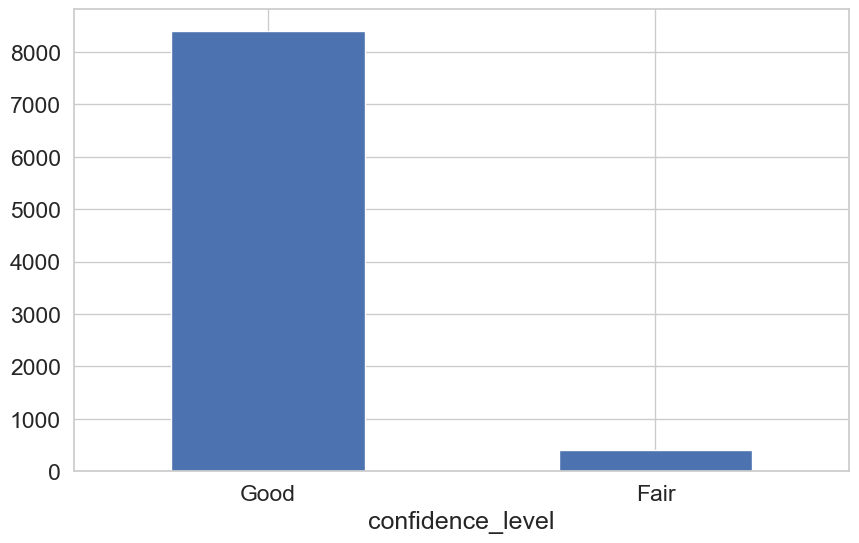

In [121]:
ax = df.confidence_level.value_counts().plot(kind='bar')
ax.tick_params(axis='x', rotation=0)

Text(0, 0.5, 'IC50 (nM)')

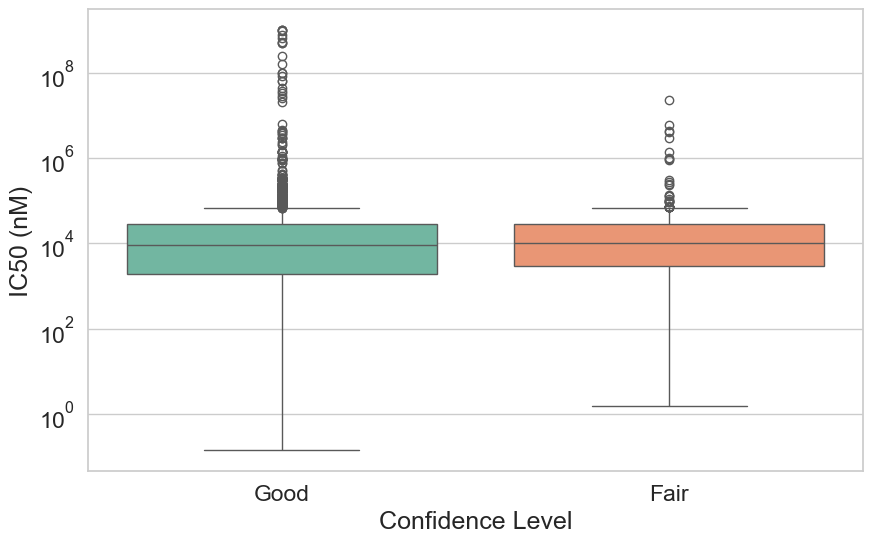

In [149]:
# Visualize the data
ax = sns.boxplot(x="confidence_level", y="standard_value", data=df, palette="Set2", hue="confidence_level")
ax.set_yscale("log")
ax.set_xlabel("Confidence Level")
ax.set_ylabel("IC50 (nM)")

